
#### This is the whole architecture of QNN

It includes data generation, matrix updating, the fundamental architecture code is from the official version of paper 1.

In [ ]:
!pip install qutip

     |████████████████████████████████| 14.7 MB 7.3 MB/s 


In [ ]:
# math related packages
import scipy as sc
import qutip as qt
# further packages
from time import time
from random import sample
import matplotlib.pyplot as plt

In [ ]:
# ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
# density matrices
qubit0mat = qubit0 * qubit0.dag() # it is also possible to use ket2dm(qubit0) 
qubit1mat = qubit1 * qubit1.dag() # it is also possible to use ket2dm(qubit1)

In [ ]:
def partialTraceKeep(obj, keep): # generalisation of ptrace(), partial trace via "to-keep" list
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialTraceRem(obj, rem): # partial trace via "to-remove" list
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

In [ ]:
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)

In [ ]:
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #for some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

In [ ]:
def unitariesCopy(unitaries): # deep copyof a list of unitaries
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

In [ ]:
def randomQubitUnitary(numQubits): # alternatively, use functions rand_unitary and rand_unitary_haar
    dim = 2**numQubits
    #Make unitary matrix
    res = sc.random.normal(size=(dim,dim)) + 1j * sc.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

In [ ]:
def randomQubitState(numQubits): # alternatively, use functions rand_ket and rand_ket_haar
    dim = 2**numQubits
    #Make normalized state
    res = sc.random.normal(size=(dim,1)) + 1j * sc.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(unitary, N): # generating training data based on a unitary
    numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        t = randomQubitState(numQubits)
        ut = unitary*t
        trainingData.append([t,ut])
    #Return
    return trainingData

In [ ]:
def randomNetwork(qnnArch, numTrainingPairs):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."
    
    #Create the targeted network unitary and corresponding training data
    networkUnitary = randomQubitUnitary(qnnArch[-1])
    networkTrainingData = randomTrainingData(networkUnitary, numTrainingPairs)
    
    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]
        
        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = randomQubitUnitary(numInputQubits+1)
            if numOutputQubits-1 != 0: 
                unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
                unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
            networkUnitaries[l].append(unitary)
    
    #Return
    return (qnnArch, networkUnitaries, networkTrainingData, networkUnitary)

In [ ]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
    return costSum.tr()/len(trainingData)

In [ ]:
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))

In [ ]:
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni
    
    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )

In [ ]:
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates

In [ ]:
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]
    
    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)
        
        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)
        
        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))
    
    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni
    
    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)
    
    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni
        
    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    res = makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)

In [ ]:
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):
    
    ### FEEDFORWARD    
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]
    
    #Optional
    runtime = time()
    
    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))
        
        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)
        
        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]
            
            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])
        
        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
        
        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
    
    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")
    
    #Return
    return [plotlist, currentUnitaries]

In [ ]:
def boundRand(D, N, n):
    return (n/N) + (N-n)/(N*D*(D+1)) * (D + min(n**2+1, D**2))

In [ ]:
def subsetTrainingAvg(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, iterations, n, alertIt=0):
    costpoints = []
    
    for i in range(iterations):
        if alertIt>0 and i%alertIt==0: print("n="+str(n)+", i="+str(i))
        
        #Prepare subset for training
        trainingSubset = sample(trainingData, n)
        
        #Train with the subset
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, trainingSubset, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])
        
        #Calculate cost with all training data
        costpoints.append(costFunction(trainingData, outputStates))
    
    return sum(costpoints)/len(costpoints)

In [ ]:
def noisyDataTraining(qnnArch, initialUnitaries, trainingData, noisyData, lda, ep, trainingRounds, numData, stepSize, alertP=0):
    noisyDataPlot = [[], []]
    
    i = 0
    while i <= numData:
        if alertP>0: print("Currently at "+str(i/numData)+"% noisy data.")
        
        #Prepare mixed data for traing
        testData1 = sample(trainingData, numData - i)
        testData2 = sample(noisyData, i)
        if i==0: testData = testData1
        elif i==numData: testData = testData2
        else: testData = testData1 + testData2
        
        #Train with the mixed data
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, testData, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])
        
        #Calculate cost with the real training data
        noisyDataPlot[0].append(i)
        noisyDataPlot[1].append(costFunction(trainingData, outputStates))
        
        i += stepSize
    
    return noisyDataPlot

I customize a QNN with size of [1,3,1]

Trained 500 rounds for a [1, 3, 1] network and 10 training pairs in 134.58 seconds
Exceeds cost of 0.95 at training step 13


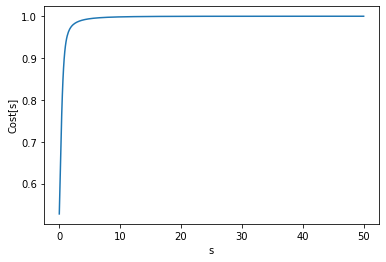

In [ ]:
network121 = randomNetwork([1,3,1], 10)
plotlist121 = qnnTraining(network121[0], network121[1], network121[2], 1, 0.1, 500)[0]

for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.95:
        print("Exceeds cost of 0.95 at training step "+str(i))
        break

plt.plot(plotlist121[0], plotlist121[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In training round 0
In training round 10
In training round 20
In training round 30
In training round 40
Trained 50 rounds for a [2, 3, 4, 4, 3, 2] network and 5 training pairs in 211.56 seconds


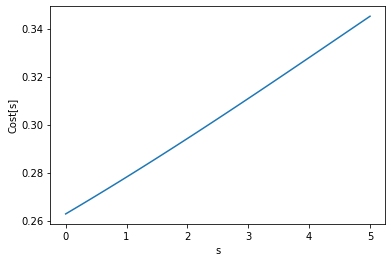

In [ ]:
#mathematica
    #run 1: 2324s = 38,7 min
    #run 2: 1501s = 25,0 min
#python
    #run 1: 545s = 9,1 min
    #run 2: 553s = 9,2 min

network23432 = randomNetwork([2,3,4,4,3,2], 5)
plotlist23432= qnnTraining(network23432[0], network23432[1], network23432[2], 4, 0.1, 50, 10)[0]

plt.plot(plotlist23432[0], plotlist23432[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In training round 0
In training round 10
In training round 20
In training round 30
In training round 40
In training round 50
In training round 60
In training round 70
In training round 80
In training round 90
Trained 100 rounds for a [2, 3, 4, 4, 3, 2] network and 5 training pairs in 422.21 seconds


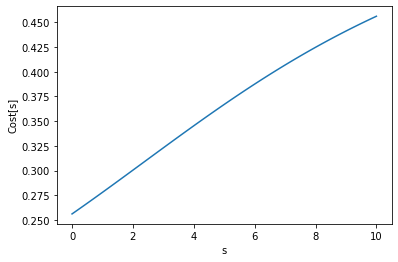

In [ ]:
network23432 = randomNetwork([2,3,4,4,3,2], 5)
plotlist23432= qnnTraining(network23432[0], network23432[1], network23432[2], 4, 0.1, 100, 10)[0]

plt.plot(plotlist23432[0], plotlist23432[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()